## 加载数据模块

In [40]:
data_path = './data/wt_lt_big.h5'
scalers_path = './data/scalers_wt_lt_big.pkl'

test_data_path = './data/wt_lt_test.h5'
test_scalers_path = './data/scalers_wt_lt_test.pkl'

model_path = './model/wtlt_big_泛化_test_2.pt'

csv_path = './results/models_comparison.csv'
model_list = [
    "./model/wtlt_big_pinn.pt",
    "./model/wtlt_big_data.pt",
    "./model/wtlt_small_pinn.pt",
    "./model/wtlt_small_data.pt",
]
model_names = ["wtlt_small_data", "wtlt_small_pinn", "wtlt_big_data", "wtlt_big_pinn"]


plt_folder_path = './results/big_4_models/'  # 用于存放绘图结果
viz_folder_path = './viz/wtlt_big_data'  # 用于存放可视化结果


In [41]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def load_data(file_path=data_path,scaler_path=scalers_path):
    # ====================
    # 1. 加载数据 + 常数参数
    # ====================
    with pd.HDFStore(file_path, 'r') as store:
        df = store['data_valid']  # 已去除NaN的样本数据
        constants = store.get_storer('data').attrs.constants
        phi_full = np.array(constants['phi'])
    # ====================
    # 2. 设置全局常数参数（转导因子）
    # ====================
    trans_factor_global = (
        constants['eps_0'] * constants['V'] * constants['electrode_length'] * constants['t'] 
        / constants['d']**2
    )
    FAC_FIXED = constants['Vac_ground'] * trans_factor_global  # Fac 是常量
    constants['mcoef_b'] = df['m_coef_b'].iloc[0]
    constants['kcoef_b'] = df['k_coef_b'].iloc[0]
    constants['kcoef_b3'] = df['k_coef_b3'].iloc[0]
    # ====================
    # 3. 从 freq, m_c 推出 omega, y
    # ====================
    def preprocess_sample(row, trans_factor):
        freq = np.array(row['freq'])  # Hz
        m_c = np.array(row['m_c'])    # 原始响应
        omega = 2 * np.pi * freq      # rad/s
        y = m_c * 1e-9 / (omega * trans_factor)
        return freq, m_c, omega, y

    omega_list, y_list, wt_list, lt_list = [], [], [], []
    freq_list, mc_list = [], []
    M_list, dkt_list, dk3t_list, Fac_list ,C_list = [], [], [], [], []

    for idx, row in df.iterrows():
        freq, m_c, omega, y = preprocess_sample(row, trans_factor_global)
        omega_list.append(omega)
        y_list.append(y)
        freq_list.append(freq)
        mc_list.append(m_c)
        wt_list.append(row['w_t'])
        lt_list.append(row['l_t'])

        # 额外参数提取
        M = row['Mass']
        dkt = row['k_tt'] - row['k_e']
        dk3t = row['k_t3'] - row['k_e3']
        Q = constants['Q']
        c = np.sqrt(M * (row['k_tt'])) / Q

        M_list.append(M)
        dkt_list.append(dkt)
        dk3t_list.append(dk3t)
        Fac_list.append(FAC_FIXED)  # 所有样本都用固定值
        C_list.append(c)
    print(f"Processed {len(omega_list)} samples.")
    # ====================
    scalers = {}
    # # input: omega, y
    # omega_norm, scalers['omega'] = fit_and_transform_scaler(omega_list, 'omega')
    # y_norm, scalers['y'] = fit_and_transform_scaler(y_list, 'y')

    # output: w_t, l_t
    wt_arr = np.array(wt_list).reshape(-1, 1)
    lt_arr = np.array(lt_list).reshape(-1, 1)

    scalers['wt'] = MinMaxScaler().fit(wt_arr)
    scalers['lt'] = MinMaxScaler().fit(lt_arr)

    wt_norm = scalers['wt'].transform(wt_arr).flatten()
    lt_norm = scalers['lt'].transform(lt_arr).flatten()

    # para: M, Δkt, Δkt3, Fac
    M_arr = np.array(M_list).reshape(-1, 1)
    dkt_arr = np.array(dkt_list).reshape(-1, 1)
    dk3t_arr = np.array(dk3t_list).reshape(-1, 1)
    Fac_arr = np.array(Fac_list).reshape(-1, 1)  # constant
    c_arr = np.array(C_list).reshape(-1, 1)

    scalers['M'] = MinMaxScaler().fit(M_arr)
    scalers['dkt'] = MinMaxScaler().fit(dkt_arr)
    scalers['dk3t'] = MinMaxScaler().fit(dk3t_arr)
    scalers['c'] = MinMaxScaler().fit(c_arr)

    # 不归一化 Fac
    Fac_norm = np.ones_like(Fac_arr.flatten())
    M_norm = scalers['M'].transform(M_arr).flatten()
    dkt_norm = scalers['dkt'].transform(dkt_arr).flatten()
    dk3t_norm = scalers['dk3t'].transform(dk3t_arr).flatten()
    c_norm = scalers['c'].transform(c_arr).flatten()


    ## 特征提取
    # ====================
    # 8. 特征统计提取函数（基于样本级别归一化 + y放大）
    # ====================
    Y_SCALE_FACTOR = 1e8  # 将 y 放大，便于统计处理

    def extract_statistical_features_per_sample(omega_list, y_list):
        feature_list = []
        sample_scalers = []
        omega_norm_list = []
        y_norm_list = []

        for omega, y in zip(omega_list, y_list):
            y_scaled = y * Y_SCALE_FACTOR
            omega_min, omega_max = np.min(omega), np.max(omega)
            y_min, y_max = np.min(y_scaled), np.max(y_scaled)
            omega_norm = (omega - omega_min) / (omega_max - omega_min + 1e-8)
            y_norm = (y_scaled - y_min) / (y_max - y_min + 1e-8)

            feat = [
                omega_min, omega_max, np.std(omega), np.mean(omega),
                y_min, y_max, np.std(y_scaled), np.mean(y_scaled),
            ]
            feature_list.append(feat)
            omega_norm_list.append(omega_norm)
            y_norm_list.append(y_norm)
            sample_scalers.append({
                'omega_min': omega_min, 'omega_max': omega_max,
                'y_min': y_min, 'y_max': y_max
            })

        return np.array(feature_list), sample_scalers, omega_norm_list, y_norm_list

    # 特征编码作为神经网络输入
    X_feat_raw, per_sample_scalers, omega_norm_all, y_norm_all = extract_statistical_features_per_sample(omega_list, y_list)

    # 将 per_sample_scalers 合并存入 scalers 中统一保存
    scalers['X_feat'] = StandardScaler().fit(X_feat_raw)
    scalers['per_sample_scalers'] = per_sample_scalers

    X_feat = scalers['X_feat'].transform(X_feat_raw)
    Y_target = np.stack([wt_norm, lt_norm], axis=1)
    Y_phys = np.stack([M_norm, dkt_norm, dk3t_norm, c_norm], axis=1)

    phi = list(df['phi'].values)

    # 统一保存所有归一化器和样本级参数
    with open(scaler_path, 'wb') as f:
        pickle.dump(scalers, f)
    print("Saved all scalers (including per-sample) to ", scaler_path)
    
    return (omega_list, y_list, wt_list, lt_list, freq_list, mc_list,
            M_list, dkt_list, dk3t_list, Fac_list, C_list,
            phi_full, constants,phi,
            X_feat, Y_target, Y_phys, omega_norm_all, y_norm_all,
            scalers, per_sample_scalers)



## 定义模型类

In [42]:
# ====================
# 网络结构定义（独立模块，基于统计特征输入）
# ====================
import torch
import torch.nn as nn
def _as_list_of_arrays(obj):
    """
    将输入安全地转为由 numpy.ndarray 组成的 list。
    支持：list[np.ndarray] / tuple[np.ndarray] / dict[key->np.ndarray] / np.ndarray(对象数组)。
    """
    if isinstance(obj, dict):
        # 如果是 dict，默认取 values 的顺序；如需稳定顺序可按 key 排序
        return [np.asarray(v) for v in obj.values()]
    if isinstance(obj, (list, tuple)):
        return [np.asarray(v) for v in obj]
    # 某些情况下可能是 object dtype 的一维数组，里面每个元素本身是数组
    obj = np.asarray(obj, dtype=object)
    return [np.asarray(x) for x in obj.tolist()]

# class PINNInverseMLP(nn.Module):
#     def __init__(self, input_dim=8, output_dim=2, hidden_dim=128, hidden_layers=4, dropout=0.0):
#         super().__init__()
#         layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
#         for _ in range(hidden_layers - 1):
#             layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
#             if dropout > 0:
#                 layers.append(nn.Dropout(dropout))
#         layers.append(nn.Linear(hidden_dim, output_dim))
#         layers.append(nn.Sigmoid())  # 强制输出在 0 ~ 1
#         self.model = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.model(x)
class PINNInverseMLP(nn.Module):
    """
    8D -> 2D 的 MLP，最后一层线性（不再 Sigmoid 夹紧）。
    输出表示由外部的 encode/decode 决定（推荐用 log-um）。
    """
    def __init__(self, input_dim=8, output_dim=2, hidden_dim=128, hidden_layers=4, dropout=0.0):
        super().__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
        layers += [nn.Linear(hidden_dim, output_dim)]  # 线性输出
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)  # 直接线性输出

print("Defined PINNInverseMLP with 8D statistical input and 2D output (wt, lt prediction).")

from torch.utils.data import Dataset, DataLoader
# ====================
# Dataset 构建
# ====================
class PINNDataset(Dataset):
    def __init__(self, X_feat, Y_target, Y_phys, phi, omega_norm_all, y_norm_all):
        self.X_feat = torch.tensor(X_feat, dtype=torch.float32)
        self.Y_target = torch.tensor(Y_target, dtype=torch.float32)
        self.Y_phys = torch.tensor(Y_phys, dtype=torch.float32)
        self.phi = phi
        self.omega_norm_all = omega_norm_all
        self.y_norm_all = y_norm_all

    def __len__(self):
        return len(self.X_feat)

    def __getitem__(self, idx):
        return {
            'X': self.X_feat[idx],
            'Y_target': self.Y_target[idx],
            'Y_phys': self.Y_phys[idx],
            'phi': self.phi[idx],
            'omega': self.omega_norm_all[idx],
            'y': self.y_norm_all[idx]
        }

print("Defined PINNDataset to provide input features, target labels, and PDE-related parameters.")

def variable_length_collate(batch):
    batch_dict = {key: [item[key] for item in batch] for key in batch[0]}
    for key in ['X', 'Y_target', 'Y_phys']:
        batch_dict[key] = torch.stack(batch_dict[key])  # only stack fixed-length tensors
    return batch_dict
# ====================
# Train/Test Split + Loader
# ====================
from sklearn.model_selection import train_test_split

def build_dataloaders(X_feat, Y_target, Y_phys, phi, omega_norm_all, y_norm_all, batch_size=32):
    idx_train, idx_test = train_test_split(np.arange(len(X_feat)), test_size=0.2, random_state=42)

    train_set = PINNDataset(
        X_feat[idx_train], Y_target[idx_train], Y_phys[idx_train],
        [phi[i] for i in idx_train],
        [omega_norm_all[i] for i in idx_train],
        [y_norm_all[i] for i in idx_train]
    )

    test_set = PINNDataset(
        X_feat[idx_test], Y_target[idx_test], Y_phys[idx_test],
        [phi[i] for i in idx_test],
        [omega_norm_all[i] for i in idx_test],
        [y_norm_all[i] for i in idx_test]
    )

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=variable_length_collate)
    test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, collate_fn=variable_length_collate)

    return train_loader, test_loader

def build_eval_loader_from_prepared(
    X_feat,
    Y_target,
    Y_phys,
    phi_full,
    omega_norm_all,
    y_norm_all,
    batch_size=32,
    shuffle=False
):
    """
    输入均为你已准备好的数组/列表/字典，返回一个与原 test_loader 完全一致的 DataLoader。
    """
    # 保证 numpy 形式（纠正你之前的小笔误）
    X_feat   = np.array(X_feat)
    Y_target = np.array(Y_target)
    Y_phys   = np.array(Y_phys)

    # 变长字段统一为 list[np.ndarray]
    # 你当前给的是：phi_full, omega_norm_all, y_norm_all
    phi_list   = _as_list_of_arrays(phi_full)
    omega_list = _as_list_of_arrays(omega_norm_all)
    y_list     = _as_list_of_arrays(y_norm_all)

    # 长度一致性检查（避免隐式错位）
    n = len(X_feat)
    assert len(Y_target) == n and len(Y_phys) == n, "Y_target/Y_phys 与 X_feat 数量不一致"
    assert len(phi_list) == n and len(omega_list) == n and len(y_list) == n, "phi/omega/y 与 X_feat 数量不一致"

    dataset = PINNDataset(
        X_feat=X_feat,
        Y_target=Y_target,
        Y_phys=Y_phys,
        phi=phi_list,
        omega_norm_all=omega_list,
        y_norm_all=y_list
    )
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=variable_length_collate)
    return loader



Defined PINNInverseMLP with 8D statistical input and 2D output (wt, lt prediction).
Defined PINNDataset to provide input features, target labels, and PDE-related parameters.


In [43]:

# 1) 读取文件
(omega_list, y_list, wt_list, lt_list, freq_list, mc_list,
 M_list, dkt_list, dk3t_list, Fac_list, C_list,
 phi_full, constants,phi,
 X_feat, Y_target, Y_phys, omega_norm_all, y_norm_all,
 scalers, per_sample_scalers) = load_data(test_data_path, test_scalers_path)

# 2) 保证定长为 numpy；纠正小笔误：Y_phys 应该来自 Y_phys 而不是 Y_target
import numpy as np
X_feat   = np.array(X_feat)
phi_list  = list(phi_full)
omega_list = list(omega_norm_all)
y_list = list(y_norm_all)

# 4) 构造与原 test_loader 同结构的 DataLoader
eval_loader = build_eval_loader_from_prepared(
    X_feat=X_feat,
    Y_target=Y_target,
    Y_phys=Y_phys,
    phi_full=phi,
    omega_norm_all=omega_list,
    y_norm_all=y_list,
    batch_size=32,
    shuffle=False
)

eval_scalers = scalers

Processed 2845 samples.
Saved all scalers (including per-sample) to  ./data/scalers_wt_lt_test.pkl


## 加载模型

In [44]:
import torch
def load_model(model_path='./model/wtlt_big_pinn.pt'):

    bundle = torch.load(model_path, map_location="cpu")
    model = bundle["model"]
    train_loader = bundle["train_loader"]
    test_loader = bundle["test_loader"]
    loss_history = bundle["loss_history"]
    scalers = bundle["scalers"]
    constants = bundle["constants"]
    return model, train_loader, test_loader, loss_history, scalers, constants

In [45]:
model, train_loader, test_loader, loss_history, scalers, constants = load_model(model_path)

/var/folders/n7/v600f1k91rjfkqj_812w6ts40000gn/T/ipykernel_60880/4045291185.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bundle = torch.load(model_path, map_location=

## 生成多个模型的误差对比文件

In [ ]:
#### 代码单元 1：get_true_pred_um
import numpy as np
import torch

def get_true_pred_um(model, dataloader, scalers, device='cpu'):
    model.eval()
    all_true, all_pred = [], []

    with torch.no_grad():
        for batch in dataloader:
            X = batch['X'].to(device)
            Y_true = batch['Y_target'].cpu().numpy()
            Y_pred = model(X).cpu().numpy()
            all_true.append(Y_true)
            all_pred.append(Y_pred)

    true_all = np.concatenate(all_true, axis=0)
    pred_all = np.concatenate(all_pred, axis=0)

    # 按你的绘图逻辑：用 scalers 反归一化到实值，再转 μm
    true_wt = scalers['wt'].inverse_transform(true_all[:, 0].reshape(-1, 1)).ravel() * 1e6
    true_lt = scalers['lt'].inverse_transform(true_all[:, 1].reshape(-1, 1)).ravel() * 1e6
    pred_wt = scalers['wt'].inverse_transform(pred_all[:, 0].reshape(-1, 1)).ravel() * 1e6
    pred_lt = scalers['lt'].inverse_transform(pred_all[:, 1].reshape(-1, 1)).ravel() * 1e6

    return true_wt, true_lt, pred_wt, pred_lt

#### 代码单元 2：evaluate_models_to_csv
import os
import pandas as pd
import numpy as np

def evaluate_models_to_csv(model_paths, eval_loader, eval_scalers, load_model_fn,
                           out_csv="./results/wtlt_models_comparison.csv", device="cpu"):
    # 用第一个模型先取 N（也可从 loader 取）
    # 这里直接从 loader 拼真值，保证每个模型对同一组样本对齐
    ytrue_list = []
    for batch in eval_loader:
        ytrue_list.append(batch['Y_target'].cpu().numpy())
    ytrue = np.concatenate(ytrue_list, axis=0)
    # 反归一化得到真值（μm），以便写入表头统一对照
    wt_true_um = eval_scalers['wt'].inverse_transform(ytrue[:, 0].reshape(-1, 1)).ravel() * 1e6
    lt_true_um = eval_scalers['lt'].inverse_transform(ytrue[:, 1].reshape(-1, 1)).ravel() * 1e6

    df = pd.DataFrame({
        "idx": np.arange(len(wt_true_um), dtype=int),
        "wt_true_um": wt_true_um,
        "lt_true_um": lt_true_um,
    })

    summary_rows = []

    for mp in model_paths:
        # 加载模型（你已有的 load_model）
        model, _, _, _, model_scalers, _ = load_model_fn(mp)
        short = os.path.splitext(os.path.basename(mp))[0]

        # 预测 & 反归一化到 μm（严格沿用你的绘图逻辑）
        wt_t, lt_t, wt_p, lt_p = get_true_pred_um(model, eval_loader, model_scalers, device=device)

        # 误差
        wt_abs = np.abs(wt_p - wt_t)
        lt_abs = np.abs(lt_p - lt_t)
        
        wt_pct = wt_abs / np.maximum(np.abs(wt_t), 1e-12) * 100.0
        lt_pct = lt_abs / np.maximum(np.abs(lt_t), 1e-12) * 100.0

        # 写入对照列
        df[f"wt_pred_um__{short}"] = wt_p
        df[f"lt_pred_um__{short}"] = lt_p
        df[f"wt_abs_err_um__{short}"] = wt_abs
        df[f"lt_abs_err_um__{short}"] = lt_abs
        df[f"wt_pct_err__{short}"] = wt_pct
        df[f"lt_pct_err__{short}"] = lt_pct

        # 简单汇总
        summary_rows.append({
            "model": short,
            "MAE_wt_um": np.mean(wt_abs),
            "MAE_lt_um": np.mean(lt_abs),
            "MAPE_wt_%": np.mean(wt_pct),
            "MAPE_lt_%": np.mean(lt_pct),
            "RMSE_wt_um": np.sqrt(np.mean((wt_p - wt_t)**2)),
            "RMSE_lt_um": np.sqrt(np.mean((lt_p - lt_t)**2)),
        })

    os.makedirs(os.path.dirname(out_csv) or ".", exist_ok=True)
    df.to_csv(out_csv, index=False)

    summary = pd.DataFrame(summary_rows).sort_values(["RMSE_wt_um", "RMSE_lt_um"])
    return df, summary


In [ ]:
# ==================== 相对均值误差：一键可视化套件 ====================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def _ensure_dir(p): os.makedirs(p, exist_ok=True)

def _nmae_nrmse_vs_axis(
    x_true,              # 用来分箱的轴：wt_true 或 lt_true（μm）
    y_true, y_pred_dict, # 计算误差的目标与每个模型的预测（μm）
    label,               # "wt" or "lt"（仅用于命名）
    save_dir, bins=20,
    norm_mode="bin_mean",  # "bin_mean"（默认）或 "global_mean"
    figsize=(8,5)
):
    """画 NMAE% / NRMSE% vs x_true 的曲线，并导出分箱统计表。"""
    _ensure_dir(save_dir)
    edges = np.linspace(x_true.min(), x_true.max(), bins+1)
    centers = 0.5*(edges[:-1] + edges[1:])
    nmae_tbl  = {m: np.full(bins, np.nan) for m in y_pred_dict}
    nrmse_tbl = {m: np.full(bins, np.nan) for m in y_pred_dict}

    global_mean = max(np.mean(y_true), 1e-12)

    for i in range(bins):
        mask = (x_true >= edges[i]) & (x_true < edges[i+1]) if i < bins-1 else (x_true >= edges[i]) & (x_true <= edges[i+1])
        if not np.any(mask): continue
        yt = y_true[mask]
        denom = max(np.mean(yt), 1e-12) if norm_mode=="bin_mean" else global_mean
        for m, yp_all in y_pred_dict.items():
            yp = yp_all[mask]
            err = yp - yt
            nmae_tbl[m][i]  = np.mean(np.abs(err))/denom*100.0
            nrmse_tbl[m][i] = np.sqrt(np.mean(err**2))/denom*100.0

    # NMAE 曲线
    plt.figure(figsize=figsize)
    for m in y_pred_dict:
        plt.plot(centers, nmae_tbl[m], marker='o', label=m)
    plt.xlabel(f"{label}_true (μm)")
    plt.ylabel(f"NMAE of {label} (%)")
    plt.title(f"NMAE({label}) vs {label}_true  [{norm_mode}]")
    plt.legend(); plt.tight_layout()
    p1 = os.path.join(save_dir, f"{label}_NMAE_vs_{label}.png")
    plt.savefig(p1, dpi=180); plt.close()

    # NRMSE 曲线
    plt.figure(figsize=figsize)
    for m in y_pred_dict:
        plt.plot(centers, nrmse_tbl[m], marker='o', label=m)
    plt.xlabel(f"{label}_true (μm)")
    plt.ylabel(f"NRMSE of {label} (%)")
    plt.title(f"NRMSE({label}) vs {label}_true  [{norm_mode}]")
    plt.legend(); plt.tight_layout()
    p2 = os.path.join(save_dir, f"{label}_NRMSE_vs_{label}.png")
    plt.savefig(p2, dpi=180); plt.close()

    # 导出分箱表
    out = pd.DataFrame({f"{label}_bin_center_um": centers})
    for m in y_pred_dict:
        out[f"NMAE_{label}_%__{m}"]  = nmae_tbl[m]
        out[f"NRMSE_{label}_%__{m}"] = nrmse_tbl[m]
    csv_path = os.path.join(save_dir, f"{label}_bins_stats_{norm_mode}.csv")
    out.to_csv(csv_path, index=False)
    return {"nmae_png": p1, "nrmse_png": p2, "bins_csv": csv_path, "table": out}

def _heatmaps_2x2_mean_normalized(
    wt_true, lt_true, wt_pred_dict, lt_pred_dict,
    model_names, save_dir, bins=40, sigma=1.0
):
    """2×2 热力图：合成均值归一化误差（%）"""
    _ensure_dir(save_dir)
    wt_mu = max(np.mean(wt_true), 1e-12)
    lt_mu = max(np.mean(lt_true), 1e-12)
    heatmaps, xedges, yedges, vmax = {}, None, None, 0.0

    for m in model_names:
        dwt = (wt_pred_dict[m]-wt_true)/wt_mu
        dlt = (lt_pred_dict[m]-lt_true)/lt_mu
        comb_pct = 100.0*np.sqrt(dwt**2 + dlt**2)

        H, xed, yed = np.histogram2d(wt_true, lt_true, bins=bins, weights=comb_pct)
        C, _, _     = np.histogram2d(wt_true, lt_true, bins=[xed, yed])
        avg = np.divide(H, C, out=np.zeros_like(H), where=C>0)
        smooth = gaussian_filter(avg.T, sigma=sigma)
        heatmaps[m] = smooth; xedges, yedges = xed, yed
        vmax = max(vmax, np.nanmax(smooth))

    fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharex=True, sharey=True)
    axes = axes.ravel()
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    for ax, m in zip(axes, model_names):
        im = ax.imshow(heatmaps[m], extent=extent, origin='lower', aspect='auto',
                       cmap='magma_r', vmin=0, vmax=vmax)
        ax.set_title(m)
        ax.set_xlabel('wt_true (μm)'); ax.set_ylabel('lt_true (μm)')
    cbar = fig.colorbar(im, ax=axes.tolist(), shrink=0.9, pad=0.02)
    cbar.set_label('Combined mean-normalized error (%)')
    plt.tight_layout()
    out_png = os.path.join(save_dir, "heatmap_2x2_mean_norm.png")
    plt.savefig(out_png, dpi=220); plt.close()
    return out_png

def _sample_table(df_cmp, model_names, k=20, save_dir="./viz/relerr_suite"):
    """按 wt/lt 的秩和排序等距抽样，导出样本对照表（含均值归一化误差%）。"""
    _ensure_dir(save_dir)
    wt = df_cmp["wt_true_um"].to_numpy()
    lt = df_cmp["lt_true_um"].to_numpy()
    from scipy.stats import rankdata
    order = np.argsort(rankdata(wt) + rankdata(lt))
    idx   = np.linspace(0, len(order)-1, num=min(k, len(order)), dtype=int)
    sel   = order[idx]

    out = pd.DataFrame({"wt_true_um": wt[sel], "lt_true_um": lt[sel]})
    wt_mu = max(np.mean(wt), 1e-12); lt_mu = max(np.mean(lt), 1e-12)

    for m in model_names:
        wp = df_cmp.loc[sel, f"wt_pred_um__{m}"].to_numpy()
        lp = df_cmp.loc[sel, f"lt_pred_um__{m}"].to_numpy()
        out[f"wt_pred_um__{m}"] = wp
        out[f"lt_pred_um__{m}"] = lp
        out[f"wt_err_meanNorm_%__{m}"] = np.abs(wp - wt[sel]) / wt_mu * 100.0
        out[f"lt_err_meanNorm_%__{m}"] = np.abs(lp - lt[sel]) / lt_mu * 100.0

    csv_path = os.path.join(save_dir, "sample_comparison_meanNorm.csv")
    out.to_csv(csv_path, index=False)
    return csv_path, out

def export_relerror_suite(
    df_cmp: pd.DataFrame,          # 含列: wt_true_um, lt_true_um, wt_pred_um__*, lt_pred_um__*
    model_names,                   # 模型短名列表（与列后缀一致）
    save_dir="./viz/relerr_suite",
    bins=20,
    norm_mode="bin_mean",          # "bin_mean"（推荐）或 "global_mean"
    heatmap_bins=40,
    heatmap_sigma=1.0,
    sample_k=20
):
    """
    生成：
      - NMAE/NRMSE 曲线（按 lt 分箱 & 按 wt 分箱），分母取分箱均值或全局均值
      - 2×2 合成均值归一化误差热力图（全局均值）
      - 样本对照表（wt/lt 递增抽样）
    """
    _ensure_dir(save_dir)

    # 取出真值与预测
    wt_true = df_cmp["wt_true_um"].to_numpy()
    lt_true = df_cmp["lt_true_um"].to_numpy()
    wt_pred_dict = {m: df_cmp[f"wt_pred_um__{m}"].to_numpy() for m in model_names}
    lt_pred_dict = {m: df_cmp[f"lt_pred_um__{m}"].to_numpy() for m in model_names}

    # ① 按 lt 分箱：评 lt 的 NMAE/NRMSE（分母为 lt 均值）
    lt_paths = _nmae_nrmse_vs_axis(
        x_true=lt_true, y_true=lt_true, y_pred_dict=lt_pred_dict,
        label="lt", save_dir=save_dir, bins=bins, norm_mode=norm_mode
    )
    # ② 按 wt 分箱：评 wt 的 NMAE/NRMSE（分母为 wt 均值）
    wt_paths = _nmae_nrmse_vs_axis(
        x_true=wt_true, y_true=wt_true, y_pred_dict=wt_pred_dict,
        label="wt", save_dir=save_dir, bins=bins, norm_mode=norm_mode
    )

    # ③ 2×2 合成均值归一化误差热力图（全局均值）
    heatmap_png = _heatmaps_2x2_mean_normalized(
        wt_true, lt_true, wt_pred_dict, lt_pred_dict,
        model_names=model_names, save_dir=save_dir,
        bins=heatmap_bins, sigma=heatmap_sigma
    )

    # ④ 样本对照表
    sample_csv, sample_df = _sample_table(df_cmp, model_names, k=sample_k, save_dir=save_dir)

    return {
        "lt_NMAE_png": lt_paths["nmae_png"],
        "lt_NRMSE_png": lt_paths["nrmse_png"],
        "lt_bins_csv": lt_paths["bins_csv"],
        "wt_NMAE_png": wt_paths["nmae_png"],
        "wt_NRMSE_png": wt_paths["nrmse_png"],
        "wt_bins_csv": wt_paths["bins_csv"],
        "heatmap_png": heatmap_png,
        "sample_table_csv": sample_csv,
        "sample_table": sample_df,
    }


In [ ]:
#### 代码单元 3：run_eval
model_list = model_list

# 你已经构造好的：
#   eval_loader  —— 新测试集 DataLoader（结构同 test_loader）
#   scalers      —— 新测试集的 scalers（来自你的 load_data）
#   load_model   —— 你现成的加载函数
csv_path = csv_path

df_cmp, summary = evaluate_models_to_csv(
    model_paths=model_list,
    eval_loader=eval_loader,
    eval_scalers=eval_scalers,
    load_model_fn=load_model,
    out_csv=csv_path,
    device="cpu"  # 或 "cuda"
)

print(f"✅ 对照表已保存: {csv_path} | 形状: {df_cmp.shape}")
print("\n=== 简要排行榜（按 RMSE_wt/lt 排）===")
print(summary.to_string(index=False, justify='center', float_format=lambda x: f"{x:.4g}"))


In [ ]:
results = export_relerror_suite(
    df_cmp=df_cmp,   # 你已有的对照表（含 wt_true_um/lt_true_um 与各模型预测列）
    model_names=model_names,
    save_dir=plt_folder_path,
    bins=20,                 # 趋势图分箱
    norm_mode="bin_mean",    # 分箱均值做分母；若想更稳定可用 "global_mean"
    heatmap_bins=40,
    heatmap_sigma=1.0,
    sample_k=20
)
print("已生成：")
for k,v in results.items():
    if isinstance(v, str):
        print(" -", k, "->", v)


## 构造可视化输出

In [46]:
## 生成可视化数据
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

from matplotlib.colors import Normalize, PowerNorm, LogNorm
from matplotlib.cm import ScalarMappable
from matplotlib import animation
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import HTML

def plot_loss_curve(loss_history,save_path=None):
    epochs = np.arange(1, len(loss_history['total']) + 1)
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, loss_history['total'], label='Total Loss')
    plt.plot(epochs, loss_history['data'], label='Data Loss')
    plt.plot(epochs, loss_history['pde'], label='PDE Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Loss curve saved to {save_path}")
    plt.show()
    
def plot_error_heatmap(model, dataloader, scalers, device='cpu', inverse=False, bins=40, sigma=1.0, save_path=None):
    model.eval()
    all_true, all_pred = [], []

    with torch.no_grad():
        for batch in dataloader:
            X = batch['X'].to(device)
            Y_true = batch['Y_target'].cpu().numpy()
            Y_pred = model(X).cpu().numpy()
            all_true.append(Y_true)
            all_pred.append(Y_pred)

    true_all = np.concatenate(all_true, axis=0)
    pred_all = np.concatenate(all_pred, axis=0)

    if inverse:
        true_wt = scalers['wt'].inverse_transform(true_all[:, 0].reshape(-1, 1)).flatten()
        true_lt = scalers['lt'].inverse_transform(true_all[:, 1].reshape(-1, 1)).flatten()
        pred_wt = scalers['wt'].inverse_transform(pred_all[:, 0].reshape(-1, 1)).flatten()
        pred_lt = scalers['lt'].inverse_transform(pred_all[:, 1].reshape(-1, 1)).flatten()
    else:
        true_wt, true_lt = true_all[:, 0], true_all[:, 1]
        pred_wt, pred_lt = pred_all[:, 0], pred_all[:, 1]

    # 计算总误差（欧几里得）
    error = np.sqrt((pred_wt - true_wt)**2 + (pred_lt - true_lt)**2)

    # 构建误差分布网格
    heatmap, xedges, yedges = np.histogram2d(true_wt, true_lt, bins=bins, weights=error)
    counts, _, _ = np.histogram2d(true_wt, true_lt, bins=[xedges, yedges])
    avg_error = np.divide(heatmap, counts, out=np.zeros_like(heatmap), where=counts > 0)

    # 模糊处理
    smoothed_error = gaussian_filter(avg_error.T, sigma=sigma)

    # 绘图
    plt.figure(figsize=(7, 5))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.imshow(smoothed_error, extent=extent, aspect='auto', origin='lower', cmap='magma_r')
    plt.colorbar(label='Smoothed Error')
    plt.xlabel('True w_t')
    plt.ylabel('True l_t')
    plt.title('Smoothed Error Heatmap (w_t & l_t)')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Heatmap saved to {save_path}")
    plt.show()
def plot_3d_error_surface(model, dataloader, scalers, device='cpu', inverse=True, grid_res=100, save_path=None):
    model.eval()
    all_true, all_pred = [], []

    with torch.no_grad():
        for batch in dataloader:
            X = batch['X'].to(device)
            Y_true = batch['Y_target'].cpu().numpy()
            Y_pred = model(X).cpu().numpy()
            all_true.append(Y_true)
            all_pred.append(Y_pred)

    true_all = np.concatenate(all_true, axis=0)
    pred_all = np.concatenate(all_pred, axis=0)

    if inverse:
        true_wt = scalers['wt'].inverse_transform(true_all[:, 0].reshape(-1, 1)).flatten()
        true_lt = scalers['lt'].inverse_transform(true_all[:, 1].reshape(-1, 1)).flatten()
        pred_wt = scalers['wt'].inverse_transform(pred_all[:, 0].reshape(-1, 1)).flatten()
        pred_lt = scalers['lt'].inverse_transform(pred_all[:, 1].reshape(-1, 1)).flatten()

        # 转为微米单位
        true_wt *= 1e6
        true_lt *= 1e6
        pred_wt *= 1e6
        pred_lt *= 1e6
    else:
        true_wt, true_lt = true_all[:, 0], true_all[:, 1]
        pred_wt, pred_lt = pred_all[:, 0], pred_all[:, 1]


    # 欧几里得误差（单位也为 μm）
    error = np.sqrt((pred_wt - true_wt)**2 + (pred_lt - true_lt)**2)  # 转为微米单位

    # 插值网格
    wt_lin = np.linspace(min(true_wt), max(true_wt), grid_res)
    lt_lin = np.linspace(min(true_lt), max(true_lt), grid_res)
    WT_grid, LT_grid = np.meshgrid(wt_lin, lt_lin)
    ERR_grid = griddata(
        points=np.vstack((true_wt, true_lt)).T,
        values=error,
        xi=(WT_grid, LT_grid),
        method='cubic'
    )

    # 绘图
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # 绘制表面 + 等高线
    surf = ax.plot_surface(WT_grid, LT_grid, np.nan_to_num(ERR_grid), cmap='magma_r', alpha=0.6)
    ax.contour(WT_grid, LT_grid, np.nan_to_num(ERR_grid), offset=0, cmap='magma_r')

    # 误差点
    ax.scatter(true_wt, true_lt, error, c=error, cmap='magma_r', edgecolor='k', s=5, alpha=0.7, label='Error')

    # 轴设置
    ax.set_xlabel('True w_t (μm)')
    ax.set_ylabel('True l_t (μm)')
    ax.set_zlabel('Prediction Error')
    ax.set_title('3D Error Surface + Contour (w_t vs l_t)')
    ax.set_xlim(true_wt.min(), true_wt.max())
    ax.set_ylim(true_lt.min(), true_lt.max())
    ax.set_zlim(0, error.max() * 1.05)

    # 科学计数法 Z 轴
    #ax.zaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1e}'))
    # 色条
    cb = fig.colorbar(surf, ax=ax, pad=0.1, shrink=0.6, aspect=15)
    cb.set_label('Prediction Error (m)')

    ax.view_init(elev=30, azim=130)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Saved 3D error plot to {save_path}")

    plt.show()
def plot_inverse_vector_field_sampled(model, dataloader, scalers, device='cpu',
                                      inverse=True, max_points=160,
                                      save_path=None):
    model.eval()
    all_true, all_pred = [], []

    with torch.no_grad():
        for batch in dataloader:
            X = batch['X'].to(device)
            Y_true = batch['Y_target'].cpu().numpy()
            Y_pred = model(X).cpu().numpy()
            all_true.append(Y_true)
            all_pred.append(Y_pred)

    true_all = np.concatenate(all_true, axis=0)
    pred_all = np.concatenate(all_pred, axis=0)

    # 返归一化
    if inverse:
        true_wt = scalers['wt'].inverse_transform(true_all[:, 0].reshape(-1, 1)).flatten()
        true_lt = scalers['lt'].inverse_transform(true_all[:, 1].reshape(-1, 1)).flatten()
        pred_wt = scalers['wt'].inverse_transform(pred_all[:, 0].reshape(-1, 1)).flatten()
        pred_lt = scalers['lt'].inverse_transform(pred_all[:, 1].reshape(-1, 1)).flatten()
        # 转为 μm
        true_wt *= 1e6
        true_lt *= 1e6
        pred_wt *= 1e6
        pred_lt *= 1e6
    else:
        true_wt, true_lt = true_all[:, 0], true_all[:, 1]
        pred_wt, pred_lt = pred_all[:, 0], pred_all[:, 1]



    # 按照 true_wt 分成 max_points 个 bin，每个 bin 选一个代表样本
    bins = np.linspace(true_wt.min(), true_wt.max(), max_points + 1)
    sampled_idx = []

    for i in range(len(bins) - 1):
        mask = (true_wt >= bins[i]) & (true_wt < bins[i + 1])
        if np.any(mask):
            idx = np.where(mask)[0][0]  # 取第一个样本
            sampled_idx.append(idx)

    sampled_idx = np.array(sampled_idx)
    tw, tl = true_wt[sampled_idx], true_lt[sampled_idx]
    pw, pl = pred_wt[sampled_idx], pred_lt[sampled_idx]

    # 差值
    u = pw - tw
    v = pl - tl
    error = np.sqrt(u**2 + v**2)

    # 使用比例误差判断（20% 阈值）
    err_ratio_wt = np.abs(pw - tw) / tw
    err_ratio_lt = np.abs(pl - tl) / tl
    high_error = (err_ratio_wt > 0.2) | (err_ratio_lt > 0.2)
    colors = np.where(high_error, 'red', 'gray')


    # 绘图
    plt.figure(figsize=(8, 8))
    plt.quiver(tw, tl, u, v, angles='xy', scale_units='xy', scale=1, color=colors, width=0.003)
    plt.scatter(tw, tl, c='black', s=10, label='True (Ground truth)')
    plt.scatter(pw, pl, c='blue', s=10, alpha=0.6, label='Predicted')
    plt.xlabel('w_t (μm)')
    plt.ylabel('l_t (μm)')
    plt.title('Inverse Prediction Trajectory ( 160 Sampled , 20% Threshold)')
    plt.legend()
    plt.grid(True)

    plt.xlim(5, 20)
    plt.ylim(100, 1000)

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Saved inverse trajectory figure to {save_path}")

    plt.tight_layout()
    plt.show()
def plot_distribution_comparison(model, dataloader, scalers, device='cpu', inverse=True, save_path=None):
    model.eval()
    all_true, all_pred = [], []

    with torch.no_grad():
        for batch in dataloader:
            X = batch['X'].to(device)
            Y_true = batch['Y_target'].cpu().numpy()
            Y_pred = model(X).cpu().numpy()
            all_true.append(Y_true)
            all_pred.append(Y_pred)

    true_all = np.concatenate(all_true, axis=0)
    pred_all = np.concatenate(all_pred, axis=0)

    # 返归一化
    if inverse:
        true_wt = scalers['wt'].inverse_transform(true_all[:, 0].reshape(-1, 1)).flatten() * 1e6
        true_lt = scalers['lt'].inverse_transform(true_all[:, 1].reshape(-1, 1)).flatten() * 1e6
        pred_wt = scalers['wt'].inverse_transform(pred_all[:, 0].reshape(-1, 1)).flatten() * 1e6
        pred_lt = scalers['lt'].inverse_transform(pred_all[:, 1].reshape(-1, 1)).flatten() * 1e6
    else:
        true_wt, true_lt = true_all[:, 0], true_all[:, 1]
        pred_wt, pred_lt = pred_all[:, 0], pred_all[:, 1]

    # 绘图
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(true_wt, color='black', label='True w_t', kde=True, stat='density', ax=axes[0])
    sns.histplot(pred_wt, color='blue', label='Predicted w_t', kde=True, stat='density', ax=axes[0], alpha=0.6)
    axes[0].set_title('w_t Distribution (μm)')
    axes[0].legend()

    sns.histplot(true_lt, color='black', label='True l_t', kde=True, stat='density', ax=axes[1])
    sns.histplot(pred_lt, color='blue', label='Predicted l_t', kde=True, stat='density', ax=axes[1], alpha=0.6)
    axes[1].set_title('l_t Distribution (μm)')
    axes[1].legend()

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Saved parameter distribution comparison to {save_path}")
    plt.show()
def extract_monotonic_samples_exhaustive(model, dataloader, scalers, device='cpu'):
    model.eval()

    wt_all, lt_all, wt_pred_all, lt_pred_all = [], [], [], []

    with torch.no_grad():
        for batch in dataloader:
            X = batch['X'].to(device)
            Y_true = batch['Y_target'].cpu().numpy()
            Y_pred = model(X).cpu().numpy()

            true_wt = scalers['wt'].inverse_transform(Y_true[:, 0].reshape(-1, 1)).flatten()
            true_lt = scalers['lt'].inverse_transform(Y_true[:, 1].reshape(-1, 1)).flatten()
            pred_wt = scalers['wt'].inverse_transform(Y_pred[:, 0].reshape(-1, 1)).flatten()
            pred_lt = scalers['lt'].inverse_transform(Y_pred[:, 1].reshape(-1, 1)).flatten()

            wt_all.extend(true_wt)
            lt_all.extend(true_lt)
            wt_pred_all.extend(pred_wt)
            lt_pred_all.extend(pred_lt)

    all_samples = list(zip(wt_all, lt_all, wt_pred_all, lt_pred_all))
    all_samples_sorted = sorted(set(all_samples), key=lambda x: (x[0], x[1]))

    # 提取最大值作为终止判断
    max_wt = max(wt_all)
    max_lt = max(lt_all)
    selected = []
    last_wt, last_lt = -np.inf, -np.inf

    for w, l, wp, lp in all_samples_sorted:
        # 已到达最大值时，跳出
        if np.isclose(last_wt, max_wt) and np.isclose(last_lt, max_lt):
            break

        # 双递增阶段
        if last_wt < max_wt and last_lt < max_lt:
            if w > last_wt and l > last_lt:
                selected.append((w, l, wp, lp))
                last_wt, last_lt = w, l

        # 仅允许 lt 增加（wt 已到最大）
        elif np.isclose(last_wt, max_wt) and last_lt < max_lt:
            if np.isclose(w, last_wt) and l > last_lt:
                selected.append((w, l, wp, lp))
                last_wt, last_lt = w, l

        # 仅允许 wt 增加（lt 已到最大）
        elif np.isclose(last_lt, max_lt) and last_wt < max_wt:
            if w > last_wt and np.isclose(l, last_lt):
                selected.append((w, l, wp, lp))
                last_wt, last_lt = w, l

    if len(selected) == 0:
        raise ValueError("❌ 没有找到可递增采样数据")

    wt_list, lt_list, wt_pred_list, lt_pred_list = zip(*selected)
    return list(wt_list), list(lt_list), list(wt_pred_list), list(lt_pred_list)



def create_beam_animation(wt, lt, wt_pred, lt_pred,
                          d_fixed=26e-6,
                          save_gif_path=None,
                          show=True):


    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    max_w = max(max(wt), max(wt_pred)) * 1.1
    max_l = max(max(lt), max(lt_pred)) * 1.1

    # 误差计算
    wt = np.array(wt)
    lt = np.array(lt)
    wt_pred = np.array(wt_pred)
    lt_pred = np.array(lt_pred)

    area_true = wt * lt
    area_pred = wt_pred * lt_pred
    error = (np.abs(area_pred - area_true) / area_true) * 100  # 单位：%


    cmap = plt.get_cmap('Spectral')
    #norm = Normalize(vmin=error.min(), vmax=error.max())
    #norm = PowerNorm(gamma=0.5, vmin=error.min(), vmax=error.max())
    norm = LogNorm(vmin=error.min(), vmax=error.max())  # 避免 vmin=0 错误
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    def plot_beam(ax, w, l, d, color='gray', alpha=1.0):
        y = [0, w, w, 0, 0]
        x = [0, 0, l, l, 0] 
        z = [0] * 5
        ax.plot3D(x, y, z, color=color, alpha=alpha)
        ax.plot3D(x, y, [d] * 5, color=color, alpha=alpha)
        for i in range(4):
            ax.plot3D([x[i], x[i]], [y[i], y[i]], [0, d], color=color, alpha=alpha)

    def update(i):
        ax.cla()
        ax.set_ylim(0, max_w * 1e6)
        ax.set_xlim(0, max_l * 1e6)
        ax.set_ylabel('Width (μm)')
        ax.set_xlabel('Length (μm)')
        ax.set_zlim(0, d_fixed * 1e6)
        ax.set_zlabel('Thickness (μm)')
        # ax.set_box_aspect([10, 2, 2.5])  # x:lt, y:wt, z:thickness
        # 添加动态视角旋转
        # azim = 45 + i * 1.5
        # elev = 20 + 10 * np.sin(np.radians(i * 2))
        # ax.view_init(elev=elev, azim=azim)  
        w_t = wt[i] * 1e6
        l_t = lt[i] * 1e6
        w_tp = wt_pred[i] * 1e6
        l_tp = lt_pred[i] * 1e6
        thick = d_fixed * 1e6
        ax.set_title(
            f"Sample {i+1} | Error = {error[i]:.1f}%\n"
            f"{'Parameter':<10} {'True':>8}    {'Pred':>8}\n"
            f"{'wt (μm)':<10} {w_t:>8.1f}  {w_tp:>8.1f}\n"
            f"{'lt (μm)':<10} {l_t:>8.1f} {l_tp:>8.1f}",
        )

        # 绘制梁
        plot_beam(ax, wt[i]*1e6, lt[i]*1e6, d_fixed*1e6, color='gray', alpha=0.8)
        color_pred = cmap(error[i])
        plot_beam(ax, wt_pred[i]*1e6, lt_pred[i]*1e6, d_fixed*1e6, color=color_pred, alpha=0.8)


    ani = animation.FuncAnimation(fig, update, frames=len(wt), interval=200)
    # 添加色条
    fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.05, pad=0.05, label='Area Error (%)')
    if save_gif_path:
        ani.save(save_gif_path, writer='pillow', fps=15,dpi=300)
        #ani.save(save_gif_path, writer='pillow', fps=10, dpi=100, savefig_kwargs={'bbox_inches': 'tight'})
        print(f"✅ Saved animation to: {save_gif_path}")

    if show:
        from IPython.display import display, HTML


        display(HTML(ani.to_jshtml()))

    plt.close()
def create_beam_object_focus_animation(wt, lt, wt_pred, lt_pred,
                                       d_fixed=26e-6,
                                       save_gif_path=None,
                                       show=True):
    import matplotlib.pyplot as plt
    from matplotlib import animation
    from matplotlib.colors import LogNorm
    from matplotlib.cm import ScalarMappable
    import numpy as np

    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    wt = np.array(wt)
    lt = np.array(lt)
    wt_pred = np.array(wt_pred)
    lt_pred = np.array(lt_pred)

    area_true = wt * lt
    area_pred = wt_pred * lt_pred
    error = (np.abs(area_pred - area_true) / area_true) * 100  # %

    cmap = plt.get_cmap('Spectral')
    norm = LogNorm(vmin=error.min(), vmax=error.max())
    sm = ScalarMappable(cmap=cmap, norm=norm)

    def plot_beam(ax, w, l, d, color='gray', alpha=1.0):
        y = [0, w, w, 0, 0]
        x = [0, 0, l, l, 0]
        z = [0] * 5
        ax.plot3D(x, y, z, color=color, alpha=alpha)
        ax.plot3D(x, y, [d] * 5, color=color, alpha=alpha)
        for i in range(4):
            ax.plot3D([x[i], x[i]], [y[i], y[i]], [0, d], color=color, alpha=alpha)

    def update(i):
        ax.cla()
        w_t = wt[i] * 1e6
        l_t = lt[i] * 1e6
        w_tp = wt_pred[i] * 1e6
        l_tp = lt_pred[i] * 1e6
        thick = d_fixed * 1e6

        # 设置视角区域聚焦梁本体
        margin = 0.2
        ax.set_xlim(0, max(l_t, l_tp) * (1 + margin))
        ax.set_ylim(0, max(w_t, w_tp) * (1 + margin))
        ax.set_zlim(0, thick * (1 + margin))
        #ax.set_box_aspect([1, 1, 0.2])
        #ax.set_xlim(0, 500)
        #ax.set_ylim(0, 10)
        #ax.set_zlim(0, 12.5)
        ax.set_box_aspect([100, 2, 2.5])  # x:lt, y:wt, z:thickness
        # 关闭轴
        ax.set_axis_off()
        # # 添加动态视角旋转
        azim = 45 + i * 1.5
        elev = 20 + 10 * np.sin(np.radians(i * 2))
        ax.view_init(elev=elev, azim=azim)
        # 添加 title
        ax.set_title(
            f"Sample {i+1} | Error = {error[i]:.1f}%\n"
            f"{'Parameter':<10} {'True':>8}    {'Pred':>8}\n"
            f"{'wt (μm)':<10} {w_t:>8.1f}  {w_tp:>8.1f}\n"
            f"{'lt (μm)':<10} {l_t:>8.1f} {l_tp:>8.1f}",
        )


        # 绘图
        plot_beam(ax, w_t, l_t, thick, color='gray', alpha=0.8)
        color_pred = cmap(norm(error[i]))
        plot_beam(ax, w_tp, l_tp, thick, color=color_pred, alpha=0.9)

    ani = animation.FuncAnimation(fig, update, frames=len(wt), interval=200)

    if save_gif_path:
        ani.save(save_gif_path, writer='pillow', fps=15,dpi = 200)
        print(f"✅ Saved animation to: {save_gif_path}")

    if show:
        from IPython.display import HTML, display
        display(HTML(ani.to_jshtml()))

    plt.close()

def output_viz_data(model, test_loader, loss_history, scalers,folder_path='./viz/wtlt_big_pinn'):
    # 如果文件夹不存在，则创建
    os.makedirs(folder_path, exist_ok=True)
    plot_loss_curve(loss_history, save_path='./viz/loss_curve_data.png')
    plot_error_heatmap(model, test_loader, scalers, device='cpu', bins=40, sigma=1.2, save_path=folder_path + '/error_heatmap.png')
    plot_3d_error_surface(model, test_loader, scalers, device='cpu', save_path=folder_path + '/3d_error_surface.png')
    plot_inverse_vector_field_sampled(
        model,
        test_loader,
        scalers,
        device='cpu',
        max_points=160,
        save_path=folder_path + '/inverse_vector_field_sampled.png'
    )
    plot_distribution_comparison(
        model,
        test_loader,
        scalers,
        device='cpu',
        save_path=folder_path + '/distribution_comparison.png'
    )
    wt_list, lt_list, wt_pred_list, lt_pred_list = extract_monotonic_samples_exhaustive(
        model, test_loader, scalers, device='cpu'
    )


    HTML_obj =create_beam_animation(
        wt_list, lt_list, wt_pred_list, lt_pred_list,
        d_fixed=25e-6,save_gif_path=folder_path+'/beam_animation.gif', show=True
    )
    create_beam_object_focus_animation(
        wt_list, lt_list, wt_pred_list, lt_pred_list,
        d_fixed=25e-6,
        show=True,
        save_gif_path= folder_path + '/beam_object_focus_animation.gif'
    )

✅ Loss curve saved to ./viz/loss_curve_data.png


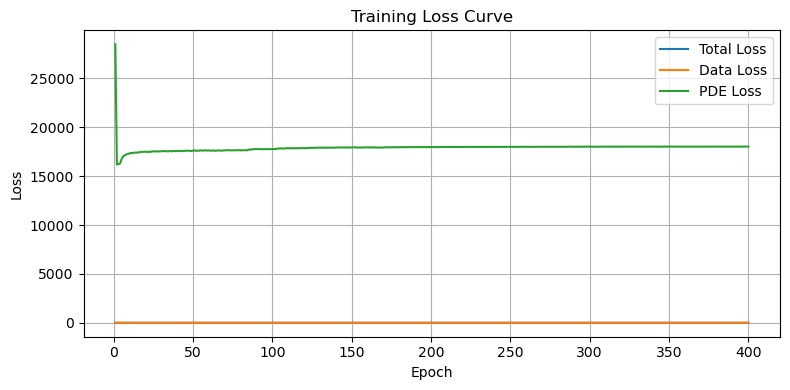

✅ Heatmap saved to ./viz/wtlt_big_data/error_heatmap.png


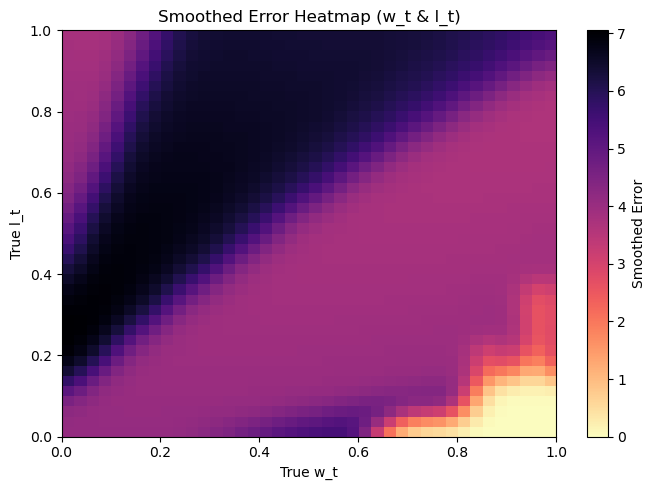

KeyError: 'wt'

In [47]:
output_viz_data(model, eval_loader, loss_history, scalers,folder_path=viz_folder_path)